In [1]:
import numpy as np
from threeflavorALLvalues import allSigmas
from scipy.integrate import odeint
from solveTmu import blackness
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import brentq, fsolve

from joblib import Parallel, delayed

import matplotlib.pyplot as plt

import pandas as pd


In [2]:
"Matching Fang paper"
v4=4.2
v3= -22.6/(6*np.sqrt(2))

def chiral(u,y,params):
    chi,chip=y
    v3,v4,lambda1,mu_g,a0,zh,q=params
    
    Q=q*zh**3
    
    
    "Ballon-Bayona version"
    phi = (mu_g*zh*u)**2-a0*(mu_g*zh*u)**3/(1+(mu_g*zh*u)**4)
    phip = 2*u*(zh*mu_g)**2+a0*(4*u**6*(zh*mu_g)**7/(1+(u*zh*mu_g)**4)**2-3*u**2*(zh*mu_g)**3/(1+(u*zh*mu_g)**4))

    f= 1 - (1+Q**2)*u**4 + Q**2*u**6
    fp= -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    "EOM for chiral field"
    derivs=[chip,
            (3/u-fp/f+phip)*chip - (3*chi+lambda1*phi*chi-3*v3*chi**2-4*v4*chi**3)/(u**2*f)]
            #((3+u**4)/(u-u**5) +phip)*chip - (-3*chi+4*v4*chi**3)/(u**2-u**6) ]
            
    return derivs

def chiral_solve_IR(d0,lambda1,T,mu,ui,uf):
    numpoints=10000
    u=np.linspace(ui,uf,numpoints)
    u_backward=np.linspace(uf,ui,numpoints)


    zeta=np.sqrt(3)/(2*np.pi)

    mu_g=440
    a0=0

    lambda3=v3
    lambda4=v4


    zh,q = blackness(T,mu)
    Q=q*zh**3
    
    #defining constants for Taylor expansion at horizon u=1

    d1 = (3 * d0 - 3 * d0**2 * lambda3 - 4 * d0**3 * lambda4 + d0 * zh**2 * lambda1 * mu_g**2) / (2 * (-2 + Q**2))

    d2 = (1 / (16 * (-2 + Q**2)**2)) * (6 * d1 * (-6 + Q**2 + Q**4) +
    4 * d0**3 * (14 - 13 * Q**2) * lambda4 + d0**2 * ((42 - 39 * Q**2) * lambda3 - 24 * d1 * (-2 + Q**2) * lambda4) -
    2 * d1 * (-2 + Q**2) * zh**2 * (-8 + 4 * Q**2 - lambda1) * mu_g**2 +
    3 * d0 * (-14 + 13 * Q**2 + 8 * d1 * lambda3 - 4 * d1 * Q**2 * lambda3 + (-2 + 3 * Q**2) * zh**2 * lambda1 * mu_g**2))
    

    "IR boundary condition"
    chi0 = d0+d1*(1-uf)+d2*(1-uf)**2
    chip0 = -d1-2*d2*(1-uf)
    y0=[chi0,chip0]




    params=v3,v4,lambda1,mu_g,a0,zh,q
    
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [uf, ui], y0, t_eval=u_backward, args=(params,))

    #sol=odeint(chiral,y0,u,args=(params,))
    #plot
    chi=sol.y[0][::-1]
    chip=sol.y[1][::-1]
 
    x=zeta*zh*ui
    #first-order approximation
    if v3==0:
        mq1=chi[0]/(zeta*zh*ui)
    else:
        #second-order approximation
       mq1=(x-x*np.sqrt(1-12*v3*chi[0]))/(6*x**2*v3)


    return mq1,chi,chip,u

def sigma_finder(u_intermediate,chi,u,mq,T,mu,zeta,lambda3):
    zh,q = blackness(T,mu)

    "find sigma"
    chi_interp=interp1d(u,chi)
    sigma=(chi_interp(u_intermediate)-mq*zeta*zh*u_intermediate+3*mq**2*zeta**2*lambda3*(zh*u_intermediate)**2)/(u_intermediate*zh)**3*zeta
    return sigma


def chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(chiral_solve_IR)(d0, lambda1, T, mu, ui, uf) for d0 in d0_array
    )
    # Unpack the results
    mq_array, chi_array, chip_array, u_array = zip(*results)
    
    return np.array(mq_array), np.array(chi_array), np.array(chip_array)

In [3]:
#run this to get the initial range of mq vs d0
#mq target should be 50 MeV or some large number
def initial_d0_mq(T,mu,mq_target,lambda1,ui,uf,d0_array):
    
#     d0_array=np.linspace(d0_lower,d0_upper,100)
    mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)[0]

    max_d0=d0_array[-1]
    # find the indices where abs(mq_array)>150, and remove those indices from d0_array and mq_array
    indices=np.where(np.abs(mq_array)>150)
    # we don't need to go higher than the lowest d0 value that gives garbage results
    # if indices is not an empty array
    if len(indices[0])>0:
        max_d0=d0_array[indices[0]]
    if len(indices[0])>1:
        max_d0=max_d0[0]

    d0_array=np.delete(d0_array,indices)
    mq_array=np.delete(mq_array,indices)
#     mq1_array=np.delete(mq1_array,indices)
    
    iterations=0
    step_size=d0_array[1]-d0_array[0]
    while mq_array[-1]<mq_target and iterations<20:
    #while max(mq_array)<mq_target and iterations<12:

        #create a new d0_array starting above the maximum value of d0_array, with a spacing that is 1/10 of the spacing of the previous d0_array
        step_size=step_size/100
        d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/20,max_d0),step_size)

        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),((d0_array[1]-d0_array[0])/100))
        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)
        d0_array=np.concatenate((d0_array,d0_new))
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)[0]
        #add the new mq_array to the old mq_array
        mq_array=np.concatenate((mq_array,mq_new))
#         mq1_array=np.concatenate((mq1_array,mq1_new))

        
        indices=np.where(np.abs(mq_array)>150)
        # we don't need to go higher than the lowest d0 value that gives garbage results
        # if indices is not an empty array
        if len(indices[0])>0:
            max_d0=d0_array[indices[0]]
        if len(indices[0])>1:
            max_d0=max_d0[0]    
        d0_array=np.delete(d0_array,indices)
        mq_array=np.delete(mq_array,indices)
#         mq1_array=np.delete(mq1_array,indices)

        # print(max_d0)
        old_max_d0=max_d0
        iterations=iterations+1
    # print('iterations',iterations)
    if mq_array[-1]-mq_array[-2]>5:
        #create an array of 10 new d0 values evenly spaced between the last two d0 values, that doesn't include either of the last two d0 values
        d0_new=np.linspace(d0_array[-2],d0_array[-1],10)[1:-1]
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)[0]
        #add the new mq_array to the old mq_array between the last two mq values, same for d0
        mq_array=np.concatenate((mq_array[:-1],mq_new,mq_array[-1:]))
        d0_array=np.concatenate((d0_array[:-1],d0_new,d0_array[-1:]))
    return d0_array,mq_array

# finding a range of d0 values that will cover quark masses in a range from 0 to approximately mq_large
# T=1
# mu=0
# mq_large=15
# lambda1=5.7
# ui=1e-4
# uf=1-ui
# numpoints=100
# d0_lower=70
# d0_upper=88
# d0_array=np.linspace(d0_lower,d0_upper,numpoints)
# d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

# d0_old=d0_array
# d0_min=d0_array[np.abs(mq_array)>1e-3][0]
# mq_array=mq_array[d0_array>d0_min]
# d0_array=d0_array[d0_array>d0_min]
# # it seems that the first two points are identical, so remove one
# d0_array=d0_array[1:]
# mq_array=mq_array[1:]
# "This works, but makes WAY too many points"
# # smallest_diff=np.min(np.gradient(d0_array))

# # d0_array=np.arange(d0_array[0],d0_array[-1]+smallest_diff,smallest_diff)

# # d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

# # solving from IR again to retain the function chi and its derivative chip for each value of d0
# _,chis,chips=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)

# #picking the value of u_int. There are 1000 points in u, so i ~ 1000*u_int
# i=10
# u=np.linspace(ui,uf,len(chips[0]))
# u_int=u[i]
# chi0=chis[:,i]
# chip0=chips[:,i]

# #solving for mq and sigma
# lambda3=v3
# zeta=np.sqrt(3)/(2*np.pi)
# zh,q=blackness(T,mu)
# # if lambda3 is nonzero, calculate mq and sigma using the improved formula
# # if lambda3 is zero, calculate mq and sigma using the round formula
# if lambda3==0:
#     sigma_improved=zeta*(chip0*u_int-chi0)/(2*u_int**3*zh**3)
#     mq_improved=mq_array#chi0/(zeta*zh*u_int)
# else:
#     mq_improved=(1-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*lambda3*zeta*u_int*zh)
#     sigma_improved=zeta*(1-6*chi0*lambda3+3*chip0*u_int*lambda3-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*u_int**3*zh**3*lambda3)



In [4]:
# The function that will run in parallel
def process_mq_target(mq_target, d0_array, mq_improved, sigma_improved, lambda1, T, mu, ui, uf, v3):
    # Your additional function calls like chiral_solve_IR, blackness go here
    
    d0_list = d0_array.tolist()
    mq_list = mq_improved.tolist()
    sigma_list = sigma_improved.tolist()
    
    indices = np.where(np.diff(np.sign(mq_improved - mq_target)))[0]
    
    results = []
    for index in indices:
        mq_approx = np.array([mq_improved[index], mq_improved[index + 1]])
        d0_approx = np.array([d0_array[index], d0_array[index + 1]])
        
        d0_interp = interp1d(mq_approx, d0_approx)
        d0 = d0_interp(mq_target)
        mq,chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
#         print(mq)
        #picking the value of u_int. There are 1000 points in u, so i ~ 1000*u_int
        i=10
        u=np.linspace(ui,uf,len(chip))
        u_int=u[i]
        chi0=chi[i]
        chip0=chip[i]

        #solving for mq and sigma
        lambda3=v3
        zeta=np.sqrt(3)/(2*np.pi)
        zh,q=blackness(T,mu)
        # if lambda3 is nonzero, calculate mq and sigma using the improved formula
        # if lambda3 is zero, calculate mq and sigma using the round formula
        if lambda3==0:
            sigma_new=zeta*(chip0*u_int-chi0)/(2*u_int**3*zh**3)
            mq_new=mq#chi0/(zeta*zh*u_int)
        else:
            mq_new=(1-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*lambda3*zeta*u_int*zh)
            sigma_new=zeta*(1-6*chi0*lambda3+3*chip0*u_int*lambda3-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*u_int**3*zh**3*lambda3)
            sigma_approx = zeta/(3*u_int**3*zh**3*lambda3)*(2*chip0*u_int-3/2*chi0)
            # sigma_improved=sigma_approx
#         print("d0=",d0)
        
        d0_list.append(d0)
        mq_list.append(mq_new)
        sigma_list.append(sigma_new)
        
    return np.array(d0_list), np.array(mq_list), np.array(sigma_list)

# # Main code
# numMass = 100
# mq_overlay = np.linspace(np.min(mq_improved), mq_large, numMass)

# results = Parallel(n_jobs=-1)(delayed(process_mq_target)(mq_target, d0_array, mq_improved, sigma_improved, lambda1, T, mu, ui, uf, v3) for mq_target in mq_overlay)

# # Aggregate results
# all_d0_arrays = [res[0] for res in results]
# all_mq_improved = [res[1] for res in results]
# all_sigma_improved = [res[2] for res in results]

# # Concatenating all the arrays
# all_d0_array = np.concatenate(all_d0_arrays)
# all_mq_improved = np.concatenate(all_mq_improved)
# all_sigma_improved = np.concatenate(all_sigma_improved)

# # Sorting by d0_array
# sort_indices = np.argsort(all_d0_array)
# all_d0_array = all_d0_array[sort_indices]
# all_mq_improved = all_mq_improved[sort_indices]
# all_sigma_improved = all_sigma_improved[sort_indices]

# # Removing duplicate d0 values
# unique_indices = np.unique(all_d0_array, return_index=True)[1]
# final_d0_array = all_d0_array[unique_indices]
# mq_improved = all_mq_improved[unique_indices]
# sigma_improved = all_sigma_improved[unique_indices]




In [5]:

def new_function(lambda1, T, mu, mq_large, ui, uf, d0_lower, d0_upper, numpoints=100):
    # Initial d0 and mq arrays
    d0_array = np.linspace(d0_lower, d0_upper, numpoints)
    d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

    # Further processing to get mq_improved and sigma_improved
    _, chis, chips = chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)  # Assuming this function exists

    i = 10
    u = np.linspace(ui, uf, len(chips[0]))
    u_int = u[i]
    chi0 = chis[:, i]
    chip0 = chips[:, i]

    lambda3 = v3  
    zeta = np.sqrt(3) / (2 * np.pi)
    zh, q = blackness(T, mu)  
    
    if lambda3 == 0:
        sigma_improved = zeta * (chip0 * u_int - chi0) / (2 * u_int ** 3 * zh ** 3)
        mq_improved = mq_array
    else:
        mq_improved =(1 - np.sqrt(1 - 3 * lambda3 * (3 * chi0 - chip0 * u_int))) / (3 * lambda3 * zeta * u_int * zh)
        sigma_improved = zeta * (1 - 6 * chi0 * lambda3 + 3 * chip0 * u_int * lambda3 - np.sqrt(1 - 3 * lambda3 * (3 * chi0 - chip0 * u_int))) / (3 * u_int ** 3 * zh ** 3 * lambda3)
        sigma_approx = zeta/(3*u_int**3*zh**3*lambda3)*(2*chip0*u_int-3/2*chi0)
        # sigma_improved = sigma_approx

    # Run process_mq_target in parallel
    numMass = 100
    mq_overlay = np.linspace(np.min(mq_improved), mq_large, numMass)
    results = Parallel(n_jobs=-1)(delayed(process_mq_target)(mq_target, d0_array, mq_improved, sigma_improved, lambda1, T, mu, ui, uf, v3) for mq_target in mq_overlay)

    # Aggregate and sort results
    all_d0_arrays = [res[0] for res in results]
    all_mq_improved = [res[1] for res in results]
    all_sigma_improved = [res[2] for res in results]
    
    all_d0_array = np.concatenate(all_d0_arrays)
    all_mq_improved = np.concatenate(all_mq_improved)
    all_sigma_improved = np.concatenate(all_sigma_improved)

    sort_indices = np.argsort(all_d0_array)
    all_d0_array = all_d0_array[sort_indices]
    all_mq_improved = all_mq_improved[sort_indices]
    all_sigma_improved = all_sigma_improved[sort_indices]

    unique_indices = np.unique(all_d0_array, return_index=True)[1]
    final_d0_array = all_d0_array[unique_indices]
    mq_improved = all_mq_improved[unique_indices]
    sigma_improved = all_sigma_improved[unique_indices]

    return mq_improved, sigma_improved, final_d0_array

# Note: The function uses variables like v3, chiral_solve_IR_parallel, blackness which should already be defined in your context.




/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41358/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


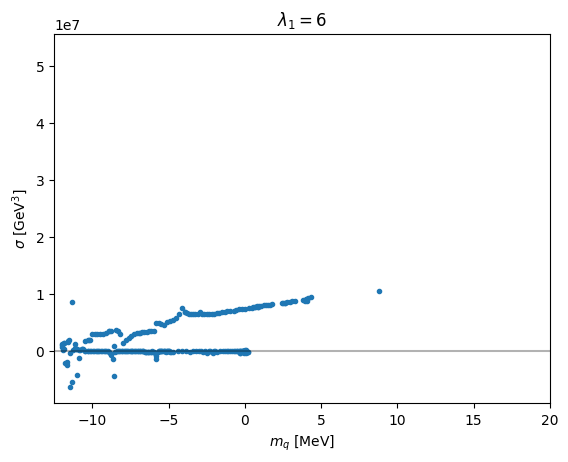

In [88]:
lambda1=6
T=40
mu=0
mq_large=5
ui=1e-4
uf=1-ui
d0_lower= -1.5
d0_upper=10

mq_improved,sigma_improved, d0_array=new_function(lambda1,T,mu,mq_large,ui,uf,d0_lower,d0_upper,numpoints=100)

plt.plot(mq_improved,sigma_improved,'.')
plt.xlim([min(mq_improved)-.5,20])
#make the ylimits from 0 to the value of sigma improved at approximately mq=20 (there may not be a value of sigma_improved at exactly mq=20)
# plt.ylim([0,sigma_improved[np.where(mq_improved>20)[0][0]]/1e9])
# plt.ylim([-220,1e6])

# plt.ylim([0,np.max(sigma_improved)/1e9])
plt.title('$\lambda_1=$'+str(lambda1))
# faint horizontal line at sigma=0
plt.axhline(0, color='black', alpha=0.3)

plt.xlabel('$m_q$ [MeV]')
plt.ylabel('$\sigma$ [GeV$^3$]')
plt.show()

In [41]:
print(np.min(d0_array),np.max(d0_array))

-2.0 3.479636363636354


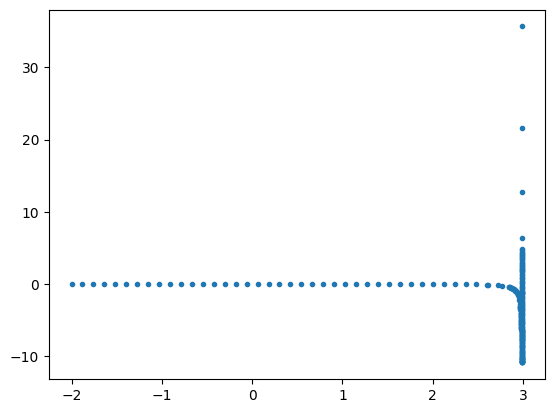

In [85]:
plt.plot(d0_array,mq_improved,'.')
# plt.xlim([min(d0_array)-.5,5])
# plt.ylim([-.01,.01])
plt.show()

In [86]:
# find the indices where mq_improved crosses zero
indices=np.where(np.diff(np.sign(mq_improved-.01)))[0]
print(indices)
# find the sigma values at those indices
print(sigma_improved[indices])
print(d0_array[indices])
print(mq_improved[indices])

[  0   6 200]
[ -84013.19616048  -18608.36929517 7393725.49071498]
[-2.         -1.27272727  2.99332763]
[-0.00096752  0.01126365 -0.09241165]


In [76]:
def crude_sigma(lambda1,T,mu,d0_lower,d0_upper,mq_input):
    mq_large=5
    ui=1e-4
    uf=1-ui
    mq_improved,sigma_improved, d0_array=new_function(lambda1,T,mu,mq_large,ui,uf,d0_lower,d0_upper,numpoints=100)

    indices=np.where(np.diff(np.sign(mq_improved-mq_input)))[0]
    return np.array(sigma_improved[indices]),np.array(mq_improved[indices])




In [193]:
rough_sigma,rough_mq=crude_sigma(5.75,65,0,d0_lower,d0_upper,0.01)

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_5515/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41358/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


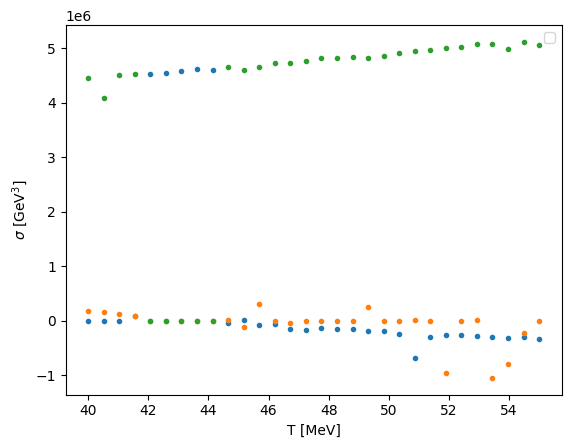

In [80]:
# create an array of 30 temperature values from 25 to 60
T_array_new=np.linspace(40,55,30)
d0_lower=-1
d0_upper=10
# create a sigma array of 3 zeros for each temperature value
sigma_array_new=np.zeros((len(T_array_new),3))
#loop over the temperature values, calculating rough_sigma and rough_mq for each temperature value
for i in range(len(T_array_new)):
    rough_sigma,_=crude_sigma(5.75,T_array_new[i],0,d0_lower,d0_upper,0.01)
    #if the length is less than 3, fill in the rest of the array with zeros
    if len(rough_sigma)<3:
        sigma_array_new[i,:len(rough_sigma)]=rough_sigma
    else:
        sigma_array_new[i]=rough_sigma[:3]

#plot the sigma values for each temperature value
for i in range(3):
    plt.plot(T_array_new,sigma_array_new[:,i],'.')
plt.xlabel('T [MeV]')
plt.ylabel('$\sigma$ [GeV$^3$]')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


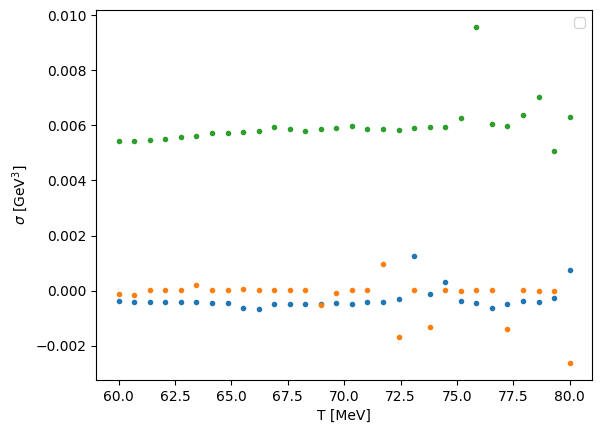

In [204]:
#plot the sigma values for each temperature value
for i in range(3):
    plt.plot(T_array_new,sigma_array_new[:,i]/1e9,'.')

plt.xlabel('T [MeV]')
plt.ylabel('$\sigma$ [GeV$^3$]')
plt.legend()
plt.show()

In [60]:
# the quark mass I want to use
mq_input=9 
mq_tolerance=0.01
# find the indices where mq_improved-mq_input changes sign
indices=np.where(np.diff(np.sign(mq_improved-mq_input)))[0]
# for each element in indices
# if one of the surrounding values of mq_improved is within mq_tolerance of mq_input, then use that value of sigma_improved
# if not, interpolate between the two surrounding vlales of d0_array
sigma_list=[]
for index in indices:
    if np.abs(mq_improved[index]-mq_input)<mq_tolerance:
        sigma_input=sigma_improved[index]
    elif np.abs(mq_improved[index+1]-mq_input)<mq_tolerance:
        sigma_input=sigma_improved[index+1]
    else:
        sigma_interp=interp1d(mq_improved[index:index+2],sigma_improved[index:index+2])
        sigma_input=sigma_interp(mq_input)
    sigma_list.append(sigma_input)
#make sigma_list into an array
sigma_values=np.array(sigma_list)
print('sigma_input^1/3=',(sigma_values)**(1/3))

sigma_input^1/3= [195.43370021]


In [11]:
def sigma_of_T(mq_input,mq_tolerance,T,mu,lambda1,d0_lower,d0_upper,ui):
    uf=1-ui
    mq_large=2*mq_input
    mq_improved,sigma_improved, d0_array=new_function(lambda1,T,mu,mq_large,ui,uf,d0_lower,d0_upper,numpoints=100)
    # find the indices where mq_improved-mq_input changes sign
    indices=np.where(np.diff(np.sign(mq_improved-mq_input)))[0]
    # for each element in indices
    # if one of the surrounding values of mq_improved is within mq_tolerance of mq_input, then use that value of sigma_improved
    # if not, interpolate between the two surrounding vlales of d0_array
    sigma_list=[]
    d0_approx_list=[]
    for index in indices:
        if np.abs(mq_improved[index]-mq_input)<mq_tolerance:
            sigma_input=sigma_improved[index]
            d0_approx=d0_array[index]
        elif np.abs(mq_improved[index+1]-mq_input)<mq_tolerance:
            sigma_input=sigma_improved[index+1]
            d0_approx=d0_array[index+1]
        else:
            sigma_interp=interp1d(mq_improved[index:index+2],sigma_improved[index:index+2])
            sigma_input=sigma_interp(mq_input)
            d0_interp=interp1d(mq_improved[index:index+2],d0_array[index:index+2])
            d0_approx=d0_interp(mq_input)
        sigma_list.append(sigma_input)
        d0_approx_list.append(d0_approx)
    #make sigma_list into an array
    sigma_values=np.array(sigma_list)
    #if sigma_values has less than three elements, pad with zeros
    if len(sigma_values)<3:
        sigma_values=np.pad(sigma_values,(0,3-len(sigma_values)),'constant')

    return sigma_values,np.max(d0_array),np.min(d0_array),d0_approx_list

quark mass= 9.00563077598218
quark mass= 8.999173612167622
quark mass= 8.993213246230559


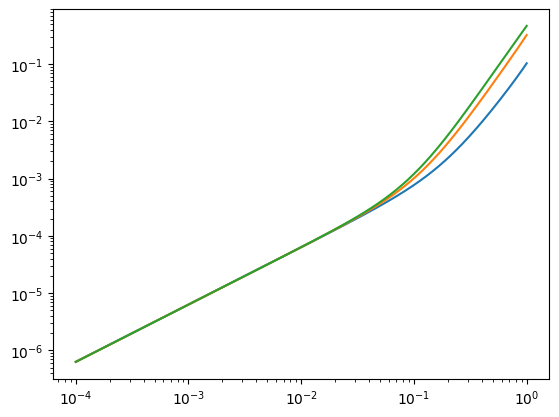

In [68]:
# find the functions chi, chip that correspond to this value of d0
# for all entries in d0_estimate
for d0 in d0_estimate:
    ui=1e-4
    mq1,chi,chip,u=chiral_solve_IR(d0,6.5,T,0,ui,1-ui)
    # find the corresponding value of sigma
    print("quark mass=",mq1)
    # print("sigma=",sig[0]**(1/3))
    plt.loglog(u,chi)
plt.show()


In [93]:
import warnings
warnings.filterwarnings('error', category=RuntimeWarning)  # Convert RuntimeWarnings to exceptions


In [104]:
def sigma_temp_scan(mq_input,mq_tolerance,lambda1,mu,tmin,tmax,numtemps,numsigma,d0_lower,d0_upper):
    T_array=np.linspace(tmin,tmax,numtemps)

    # create a numpy array of zeros with 3 by numtemps elements to store the sigma values
    sigma_array=np.zeros((numsigma,numtemps))
    for i in range(numtemps):
        d0_adjustment_step = 0.1  # The step by which to adjust d0_lower if an error occurs
        max_attempts = 10  # Maximum number of adjustments to attempt

        success = False
        for attempt in range(max_attempts):
            try:
                ui=1e-2
                sigma_array[:,i],d0_max,d0_min,_=sigma_of_T(mq_input,mq_tolerance,T_array[i],mu,lambda1,d0_lower,d0_upper,ui)
                success = True  # If sigma_temp_scan succeeds, break out of the loop
                break
            except RuntimeWarning as e:
                print(f"Runtime warning encountered: {e}. Adjusting d0_lower and retrying...")
                d0_lower += d0_adjustment_step
            except Exception as e:
                print(f"An error occurred: {e}. Adjusting d0_lower and retrying...")
                d0_lower += d0_adjustment_step
        # try:
        #     ui=1e-2
        #     # Existing line
        #     # sigma_array[:,i],d0_max,d0_min,_=sigma_of_T(mq_input,mq_tolerance,T_array[i],mu,lambda1,d0_lower,d0_upper,ui)

        #     # # Modified line
        #     # sigma_temp,d0_max,d0_min,_ = sigma_of_T(mq_input, mq_tolerance, T_array[i], mu, lambda1, d0_lower, d0_upper, ui)
        #     # # sorted_sigma = np.sort(sigma_temp)  # Sort the values
        #     # sigma_array[:, i] = sigma_temp[:numsigma] if sigma_temp.size >= numsigma else sigma_temp  # Take first numsigma or fewer
        #     sigma_temp, d0_max, d0_min, _ = sigma_of_T(mq_input, mq_tolerance, T_array[i], mu, lambda1, d0_lower, d0_upper, ui)
        #     sigma_temp = np.pad(sigma_temp[:numsigma], (0, max(0, numsigma - sigma_temp.size)), 'constant')
        #     sigma_array[:, i] = sigma_temp
        #     # print(d0_min)
        # except:
        #     ui=1e-4
        #     sigma_array[:,i],d0_max,d0_min,_=sigma_of_T(mq_input,mq_tolerance,T_array[i],mu,lambda1,d0_lower,d0_upper,ui)
        # every 10 iterations, print the temperature
        if i%10==0:
            print("Temperature is ", T_array[i])
        # d0_upper=d0_max
        # d0_lower=max(0,d0_min/2)
    return T_array,sigma_array
    


In [109]:


#maximum number of sigma values to store at each temperature
numsigma=3

lambda1=6
mq_input=1e-2
mq_tolerance=1e-4
mu=0

tmin=28 
tmax=110
spacing=2
#create an array of T values from tmin to tmax with a spacing of 0.5
#make this an integer: numtemps=round(tmax-tmin)/spacing
numtemps=(tmax-tmin)*spacing
d0_lower=-2
d0_upper=20
T_array_low, sigma_array_low = sigma_temp_scan(mq_input,mq_tolerance,lambda1,mu,tmin,tmax,numtemps,numsigma,d0_lower,d0_upper)






/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41358/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  28.0
Temperature is  33.030674846625764
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
Temperature is  38.06134969325153


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41358/1446935064.py:77: RuntimeWarning: invalid value encountered in sqrt
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41358/1446935064.py:77: RuntimeWarning: invalid value encountered in sqrt


An error occurred: too many indices for array: array is 1-dimensional, but 2 were indexed. Adjusting d0_lower and retrying...
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
Temperature is  43.0920245398773
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
Temperature is  48.122699386503065
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
Temperature is  53.15337423312883
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
Temperature is  58.1840490797546
An error occurred:

/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Temperature is  63.214723926380366
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
Temperature is  68.24539877300613
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
An error occurred: could not broadcast input array from shape (5,) into shape (3,). Adjusting d0_lower and retrying...
Temperature is  73.2760736196319
Temperature is  78.30674846625766
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
Temperature is  83.33742331288343
Temperature is  88.3680981595092
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
Temperature is  93.39877300613497
Temperature is  98.42944785276073
Temperature is  103.4601226993865
Temperature is  108.49079754601226


In [105]:
tmin=103
tmax=110
spacing=2

numtemps=(tmax-tmin)*spacing
d0_lower=0
d0_upper=20
T_array_high, sigma_array_high = sigma_temp_scan(mq_input,mq_tolerance,lambda1,mu,tmin,tmax,numtemps,numsigma,d0_lower,d0_upper)

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41358/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  103.0
Temperature is  108.38461538461539


In [106]:
tmin=50
tmax=66
spacing=2
numtemps=(tmax-tmin)*spacing
d0_lower= -1.5
d0_upper=10
T_array_mid, sigma_array_mid = sigma_temp_scan(mq_input,mq_tolerance,lambda1,mu,tmin,tmax,numtemps,numsigma,d0_lower,d0_upper)

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41358/1446935064.py:77: RuntimeWarning: invalid value encountered in sqrt
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41358/1446935064.py:77: RuntimeWarning: invalid value encountered in sqrt
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41358/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41358/1446935064.py:77: RuntimeWarning: invalid value encountered in sqrt
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41358/1446935064.py:77: RuntimeWarning: invalid value encountered in sqrt
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T

An error occurred: too many indices for array: array is 1-dimensional, but 2 were indexed. Adjusting d0_lower and retrying...


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41358/1446935064.py:77: RuntimeWarning: invalid value encountered in sqrt


An error occurred: too many indices for array: array is 1-dimensional, but 2 were indexed. Adjusting d0_lower and retrying...
Temperature is  50.0
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
Temperature is  55.16129032258065
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
Temperature is  60.32258064516129
An error occurred: not enough values to unpack (expected 4, got 0). Adjusting d0_lower and retrying...
Temperature is  65.48387096774194


In [ ]:
tmin=45

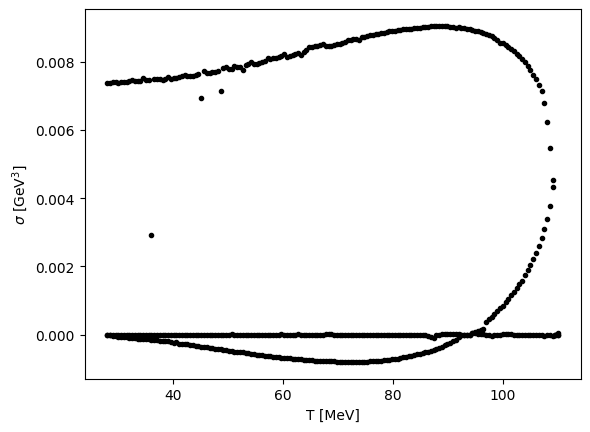

In [110]:
#plot the sigma values for each temperature value
for i in range(numsigma):
    plt.plot(T_array_low,sigma_array_low[i]/1e9,'.',color='black')
    # plt.plot(T_array_mid,sigma_array_mid[i]/1e9,'.',color='black')
    # plt.plot(T_array_high,sigma_array_high[i]/1e9,'.',color='black')

plt.xlabel('T [MeV]')
plt.ylabel('$\sigma$ [GeV$^3$]')
plt.show()

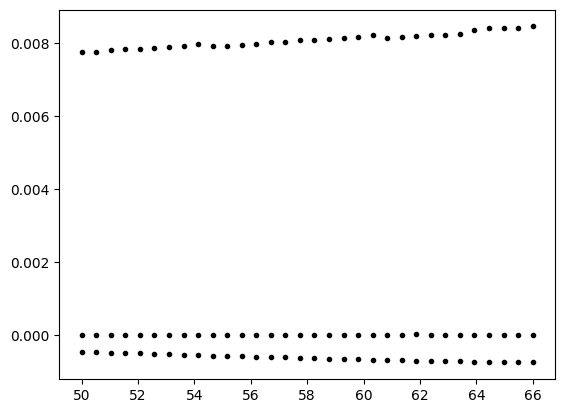

In [108]:
for i in range(numsigma):
    plt.plot(T_array_mid,sigma_array_mid[i]/1e9,'.',color='black')
plt.show()

In [103]:
# concatenate the arrays of T values and sigma values
T_array_575=np.concatenate((T_array_super_low,T_array_low,T_array_mid,T_array_high))
sigma_array_575=np.concatenate((sigma_array_super_low,sigma_array_low,sigma_array_mid,sigma_array_high),axis=1)


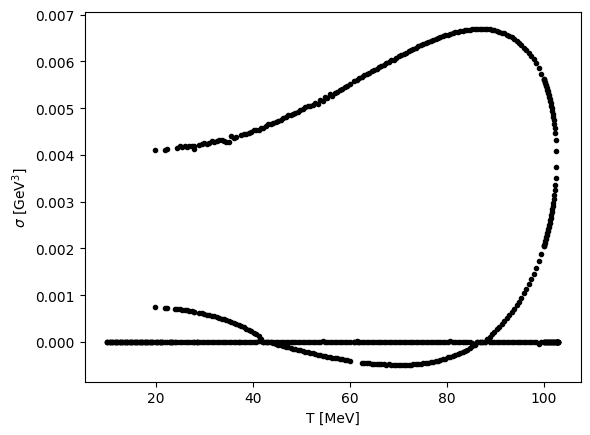

In [104]:
#plot the sigma values for each temperature value
for i in range(numsigma):
    plt.plot(T_array_575,sigma_array_575[i]/1e9,'.',color='black')
plt.xlabel('T [MeV]')
plt.ylabel('$\sigma$ [GeV$^3$]')
plt.show()

In [107]:
# export the arrays of T values and sigma values to a csv file
df=pd.DataFrame(T_array_575)
df.to_csv('data/T_array_575.csv',index=False)
df=pd.DataFrame(sigma_array_575)
df.to_csv('data/sigma_array_575.csv',index=False)


In [ ]:
# now read in the csv file
T_array_575=pd.read_csv('T_array_575.csv').to_numpy()
sigma_array_575=pd.read_csv('sigma_array_575.csv').to_numpy()

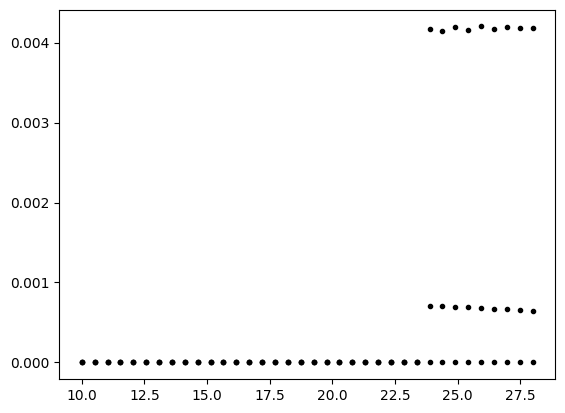

In [93]:
for i in range(numsigma):
    plt.plot(T_array_super_low,sigma_array_super_low[i]/1e9,'.',color='black')
plt.show()

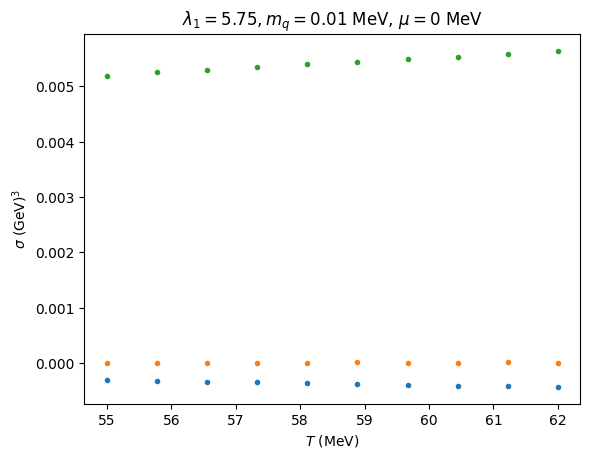

In [27]:
plt.plot(T_array,sigma_array[0,:]/1e9,'.')
plt.plot(T_array,sigma_array[1,:]/1e9,'.')
plt.plot(T_array,sigma_array[2,:]/1e9,'.')

plt.xlabel('$T$ (MeV)')
plt.ylabel('$\sigma$ (GeV)$^3$')
# plt.ylim([np.min(sigma_array[0,:]/1e9),1.1*np.max(sigma_array[0,:]/1e9)])
plt.title('$\lambda_1=$'+str(lambda1)+'$, m_q=$'+str(mq_input)+' MeV, $\mu= $'+str(mu)+' MeV')
plt.show()

In [169]:
T_array_1=T_array
sigma_array_1=sigma_array

In [171]:
sigma_array_1[:,-1]

array([-4.01423139e+05,  5.15032193e+02,  5.50660329e+06])

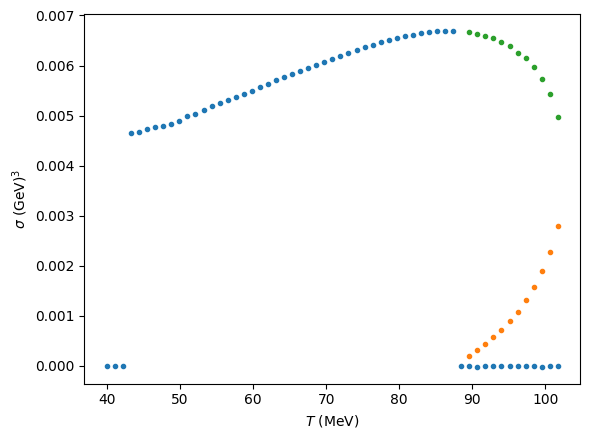

In [735]:
nonzero1 = np.nonzero(sigma_array[0, :])
sigma_array1 = sigma_array[0, :][nonzero1]
T_array1 = T_array[nonzero1]

nonzero2 = np.nonzero(sigma_array[1, :])
sigma_array2 = sigma_array[1, :][nonzero2]
T_array2 = T_array[nonzero2]

nonzero3 = np.nonzero(sigma_array[2, :])
sigma_array3 = sigma_array[2, :][nonzero3]
T_array3 = T_array[nonzero3]

#find the temperature value where abs( gradient of sigma_array1 ) is largest
gradient1=np.gradient(sigma_array1,T_array1)
max_gradient1=np.max(np.abs(gradient1))
#find the temperature where max_gradient1 occurs
T_c=T_array1[np.where(np.abs(gradient1)==max_gradient1)[0][0]]

# remove all the values from T_array2 and T_array3 that are less than T_c, and all the corresponding values from sigma_array2 and sigma_array3
sigma_array2=sigma_array2[T_array2>T_c]
T_array2=T_array2[T_array2>T_c]
sigma_array3=sigma_array3[T_array3>T_c]
T_array3=T_array3[T_array3>T_c]

plt.plot(T_array1, sigma_array1/1e9, '.')
plt.plot(T_array2, sigma_array2/1e9, '.')
plt.plot(T_array3, sigma_array3/1e9, '.')
plt.xlabel('$T$ (MeV)')
plt.ylabel('$\sigma$ (GeV)$^3$')
plt.show()


In [730]:
T_c

89.49152542372882

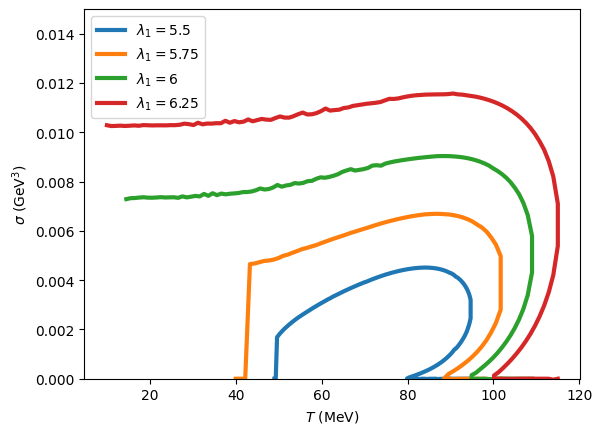

In [739]:
# Reverse the order of the arrays where the plot goes "backward"
T_array2 = T_array2[::-1]
sigma_array2 = sigma_array2[::-1]

# Find the index where the gradient of sigma_array1 is most negative
splitIndex1 = np.argmin(np.gradient(sigma_array1))

# Split sigma_array1 and T_array1 into two arrays at the index where the gradient is most negative
sigma_array1a = sigma_array1[:splitIndex1]
sigma_array1b = sigma_array1[splitIndex1:]
T_array1a = T_array1[:splitIndex1]
T_array1b = T_array1[splitIndex1:]

# Join the arrays in the following order sigma_array1a, sigma_array3, sigma_array2, sigma_array1b
sigma_array_new = np.concatenate((sigma_array1a, sigma_array3, sigma_array2, sigma_array1b))
T_array_new = np.concatenate((T_array1a, T_array3, T_array2, T_array1b))

# Plot the final sigma_array vs T_array
# make the line thicker

plt.plot(T_array_lambda_5_5, sigma_array_lambda_5_5/1e9, linewidth=3)
plt.plot(T_array_lambda_5_75, sigma_array_lambda_5_75/1e9, linewidth=3)
plt.plot(T_array_lambda_6, sigma_array_lambda_6/1e9, linewidth=3)
plt.plot(T_array_lambda_6_25, sigma_array_lambda_6_25/1e9, linewidth=3)
# plt.plot(T_array_new, sigma_array_new/1e9, linewidth=3)
#create a legend labeling the lines by their lambda1 values
plt.legend(['$\lambda_1=5.5$','$\lambda_1=5.75$','$\lambda_1=6$', '$\lambda_1=6.25$'])
plt.ylim([0,.015])
plt.xlabel('$T$ (MeV)')
plt.ylabel('$\sigma$ (GeV$^3$)')   
plt.show()

# # save the plot as a png and an eps file with the name sigma_vs_T and the appropriate lambda1, mq_input, and mu values
# plt.savefig('sigma_vs_T_lambda1_compare4_mq='+str(mq_input)+'_mu='+str(mu)+'.png')
# plt.savefig('sigma_vs_T_lambda1_compare4_mq='+str(mq_input)+'_mu='+str(mu)+'.eps')
plt.show()


In [737]:
sigma_array_lambda_5_75=sigma_array_new
T_array_lambda_5_75=T_array_new

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_14139/3415588007.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


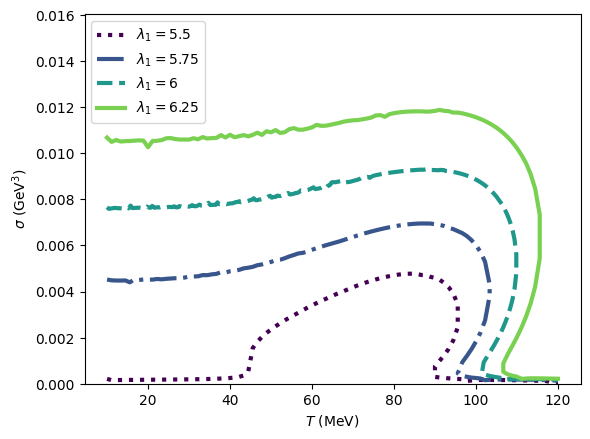

In [385]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Number of lines
n_lines = 4

# Create a color map, excluding the upper end of the viridis spectrum
cmap = cm.get_cmap('viridis')
color_indices = np.linspace(0, 0.8, n_lines)  # Stopping at 0.8 to avoid the lightest colors

plt.plot(T_array_lambda_5_5, sigma_array_lambda_5_5/1e9, linestyle=':', color=cmap(color_indices[0]), linewidth=3)
plt.plot(T_array_lambda_5_75, sigma_array_lambda_5_75/1e9, linestyle='-.', color=cmap(color_indices[1]), linewidth=3)
plt.plot(T_array_lambda_6, sigma_array_lambda_6/1e9, linestyle='--', color=cmap(color_indices[2]), linewidth=3)
plt.plot(T_array_lambda_6_25, sigma_array_lambda_6_25/1e9, linestyle='-', color=cmap(color_indices[3]), linewidth=3)

plt.legend(['$\lambda_1=5.5$', '$\lambda_1=5.75$', '$\lambda_1=6$', '$\lambda_1=6.25$'])
plt.ylim([0, 1.35 * np.max(sigma_array_new/1e9)])
plt.xlabel('$T$ (MeV)')
plt.ylabel('$\sigma$ (GeV$^3$)')


# save the plot as a png and an eps file with the name sigma_vs_T and the appropriate lambda1, mq_input, and mu values
plt.savefig('sigma_vs_T_lambda1_compare4_mq='+str(mq_input)+'_mu='+str(mu)+'_viridis.png')
plt.savefig('sigma_vs_T_lambda1_compare4_mq='+str(mq_input)+'_mu='+str(mu)+'_viridis.eps')
plt.show()


In [371]:
T_array_lambda_6_25=T_array_new
sigma_array_lambda_6_25=sigma_array_new

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_14139/2660019216.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


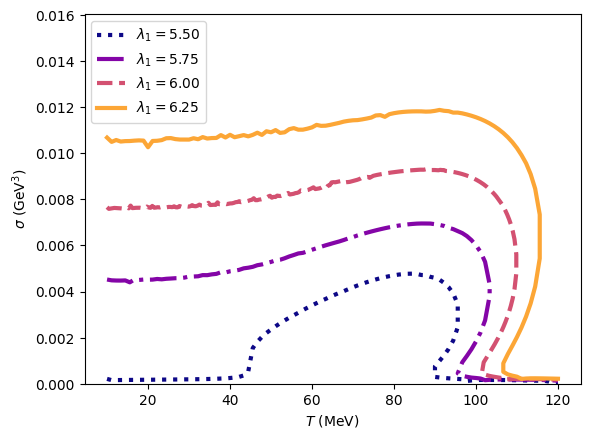

In [395]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Number of lines
n_lines = 4

# Create a color map, excluding the upper end of the plasma spectrum
cmap = cm.get_cmap('plasma')
color_indices = np.linspace(0, 0.8, n_lines)  # Stopping at 0.8 to avoid the lightest colors

plt.plot(T_array_lambda_5_5, sigma_array_lambda_5_5/1e9, linestyle=':', color=cmap(color_indices[0]), linewidth=3)
plt.plot(T_array_lambda_5_75, sigma_array_lambda_5_75/1e9, linestyle='-.', color=cmap(color_indices[1]), linewidth=3)
plt.plot(T_array_lambda_6, sigma_array_lambda_6/1e9, linestyle='--', color=cmap(color_indices[2]), linewidth=3)
plt.plot(T_array_lambda_6_25, sigma_array_lambda_6_25/1e9, linestyle='-', color=cmap(color_indices[3]), linewidth=3)

#force the legend to be in the top left
plt.legend(['$\lambda_1=5.50$', '$\lambda_1=5.75$', '$\lambda_1=6.00$', '$\lambda_1=6.25$'],loc='upper left')
plt.ylim([0, 1.35 * np.max(sigma_array_new/1e9)])
plt.xlabel('$T$ (MeV)')
plt.ylabel('$\sigma$ (GeV$^3$)')



# save the plot as a png and an eps file with the name sigma_vs_T and the appropriate lambda1, mq_input, and mu values
plt.savefig('sigma_vs_T_lambda1_compare4_mq='+str(mq_input)+'_mu='+str(mu)+'_plasma_extra_sigfigs.png')
plt.savefig('sigma_vs_T_lambda1_compare4_mq='+str(mq_input)+'_mu='+str(mu)+'_plasma_extra_sigfigs.eps')
plt.show()


In [397]:
#export the data to four different csv files because the arrays are different lengths
import pandas as pd
df1=pd.DataFrame({'T':T_array_lambda_5_5,'sigma':sigma_array_lambda_5_5})
df2=pd.DataFrame({'T':T_array_lambda_5_75,'sigma':sigma_array_lambda_5_75})
df3=pd.DataFrame({'T':T_array_lambda_6,'sigma':sigma_array_lambda_6})
df4=pd.DataFrame({'T':T_array_lambda_6_25,'sigma':sigma_array_lambda_6_25})
df1.to_csv('sigma_vs_T_lambda1_5_5.csv')
df2.to_csv('sigma_vs_T_lambda1_5_75.csv')
df3.to_csv('sigma_vs_T_lambda1_6.csv')
df4.to_csv('sigma_vs_T_lambda1_6_25.csv')

# import the data from the csv files
df1=pd.read_csv('sigma_vs_T_lambda1_5_5.csv')
df2=pd.read_csv('sigma_vs_T_lambda1_5_75.csv')
df3=pd.read_csv('sigma_vs_T_lambda1_6.csv')
df4=pd.read_csv('sigma_vs_T_lambda1_6_25.csv')
#put the data back into numpy arrays
T_array_lambda_5_5=df1['T'].to_numpy()
sigma_array_lambda_5_5=df1['sigma'].to_numpy()
T_array_lambda_5_75=df2['T'].to_numpy()
sigma_array_lambda_5_75=df2['sigma'].to_numpy()
T_array_lambda_6=df3['T'].to_numpy()
sigma_array_lambda_6=df3['sigma'].to_numpy()
T_array_lambda_6_25=df4['T'].to_numpy()
sigma_array_lambda_6_25=df4['sigma'].to_numpy()





# Solving from UV for comparison

In [552]:
from criticalZoom import allSigmas, get_all_sigmas_parallel, get_all_sigmas
import numpy as np
import os
from multiprocessing import Pool

def get_all_sigmas_parallel(allSigmas, tempsArgs, pool):
    # Replace this function with your actual implementation
    # This is just a placeholder to illustrate the parallel processing
    return pool.map(allSigmas, tempsArgs)

# Your provided code, adapted for a Jupyter notebook
tmin = 10
tmax = 120
numtemp = 50

temps = np.linspace(tmin, tmax, numtemp)

# Light quark mass
ml = 1 * np.ones(numtemp)

# Chemical potential
mu = 0 * np.ones(numtemp)

lambda1 = 5.5 * np.ones(numtemp)  # Parameter for mixing between dilaton and chiral field

minsigma = 10 * np.ones(numtemp)
maxsigma = 200 * np.ones(numtemp)

a0 = 0. * np.ones(numtemp)

tempsArgs = np.array([temps, mu, ml, minsigma, maxsigma, a0, lambda1]).T

# The function 'allSigmas' needs to be defined or imported
# truesigma = get_all_sigmas(allSigmas, tempsArgs)  # Old version

# Create a pool that uses all available CPUs
processes_count = os.cpu_count()
with Pool(processes_count) as pool:
    truesigma = get_all_sigmas_parallel(allSigmas, tempsArgs, pool)
    truesigma_5_5 = np.array(truesigma)

# Rest of your processing...


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/Documents/GitHub/DilatonMixingParallel/criticalZoom.py:166: RuntimeWarning: overflow encountered in square
  test = ((-u**2*fp)/f)*chiFields[:,1]-1/f*(3*chiFields[:,0]+lambda1*phi*chiFields[:,0]-3*v3*chiFields[:,0]**2-4*v4*chiFields[:,0]**3)
/Users/seanbartz/Documents/GitHub/DilatonMixingParallel/criticalZoom.py:166: RuntimeWarning: overflow encountered in power
  test = ((-u**2*fp)/f)*chiFields[:,1]-1/f*(3*chiFields[:,0]+lambda1*phi*chiFields[:,0]-3*v3*chiFields[:,0]**2-4*v4*chiFields[:,0]**3)
/Users/seanbartz/Documents/GitHub/DilatonMixingParallel/criticalZoom.py:166: RuntimeWarning: invalid value encountered in subtract
  test = ((-u**2*fp)/f)*chiFields[:,1]-1/f*(3*chiFields[:,0]+lambda1*phi*chiFields[

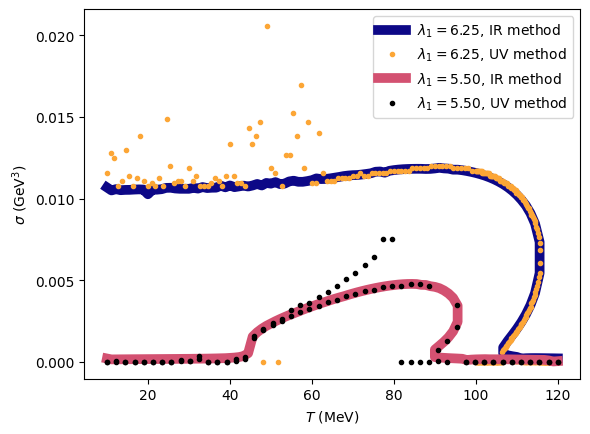

In [567]:
plt.plot(T_array_lambda_6_25, sigma_array_lambda_6_25/1e9, linestyle='-', color=cmap(color_indices[0]), linewidth=7,label='$\lambda_1=6.25$, IR method')
plt.plot(lowtemps_6_25,truesigma_low_T_6_25[:,0]**3/1e9,'.',color=cmap(color_indices[3]),label = '$\lambda_1=6.25$, UV method')
plt.plot(hightemps_6_25,truesigma_6_25**3/1e9,'.',color=cmap(color_indices[3]))
plt.plot(T_array_lambda_5_5, sigma_array_lambda_5_5/1e9, linestyle='-', color=cmap(color_indices[2]), linewidth=7, label = '$\lambda_1=5.50$, IR method')
plt.plot(temps,truesigma_5_5[:,0]**3/1e9,'.',color='black', label = '$\lambda_1=5.50$, UV method')
plt.plot(temps,truesigma_5_5[:,1:2]**3/1e9,'.',color='black')
# plt.plot(T_array_lambda_5_75, sigma_array_lambda_5_75/1e9, linestyle='-', color=cmap(color_indices[1]), linewidth=5, label = '$\lambda_1=5.75$, IR method')

plt.legend()

plt.xlabel('$T$ (MeV)')
plt.ylabel('$\sigma$ (GeV$^3$)')
plt.show()

# Zooming in to find transition temperature

Start with a large temperature range, and zoom in on the temperature with the largest gradient in $\sigma$. 

Continue until either:
- A First-order phase transition is found ($\sigma$ is multi-valued)
- The temperature range is within a specified value

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_14139/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  93.57142857142857
first-order transition at T= 93.57142857142857
Tc= 89.64285714285714 transition_order= 1


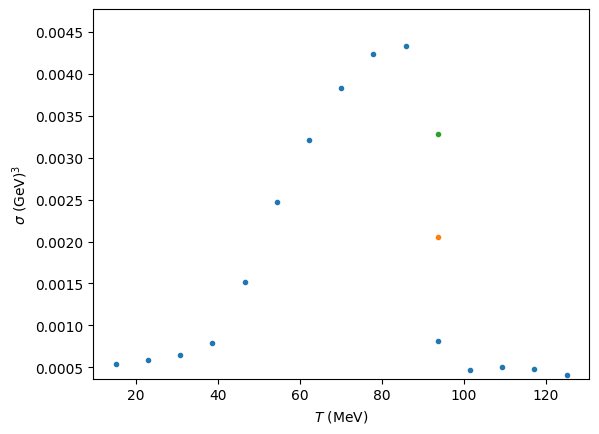

In [203]:
# find the index where the gradient of sigma_array[0,:] is most negative
# this is the index where the approximate transition temperature is

tmin=15
tmax=125
numtemps=15

lambda1=5.36875
mq_input=3.5
mq_tolerance=0.01
mu=0

def sigma_zoom(mq_input,mq_tolerance, lambda1,mu,tmin,tmax,numtemps):

    iterations = 0
    order = 2
    delta_Tc=100

    while(order==2 and iterations<10 and delta_Tc>0.0001):
        iterations=iterations+1
        # print("iteration number ",iterations)
        T_array, sigma_array = sigma_temp_scan(mq_input,mq_tolerance,lambda1,mu,tmin,tmax,numtemps)

        transition_index=np.argmin(np.gradient(sigma_array[0,:]))

        #check to see if sigma_array[1,:] has any non-zero values near the transition temperature
        if transition_index+2>len(sigma_array[1,:]):
            max_index=len(sigma_array[1,:])-1
        else:
            max_index=transition_index+2

        min_index=max(0,transition_index-1)
        if max_index == transition_index:
            transition_index=transition_index-1
        # print("indices are ",min_index,max_index)
        if np.max(sigma_array[1,transition_index:max_index])>0:
            # the transition is first-order
            order = 1
            # the transition index is the smallest index in this range where sigma_array[1,:] is nonzero
            nonzero_indices=np.where(sigma_array[1,:]!=0)[0]
            #keep only the elements of nonzero_indices that are greater than or equal to transition_index-1 and less than or equal to max_index
            nonzero_indices=nonzero_indices[(nonzero_indices>=transition_index-1) & (nonzero_indices<=max_index)]
            #the transition occurs at the smallest of these temperatures
            transition_index=nonzero_indices[0]
            print('first-order transition at T=',T_array[transition_index])
        else:
            # no evidence of a first-order transition
            # the transition is in the range of T_array[transition_index-1] to T_array[transition_index+1]
            print('Phase transition between T=',T_array[min_index],' and T=',T_array[min(max_index,len(T_array)-1)])
            tmin=T_array[max(0,transition_index-1)]
            tmax=T_array[min(max_index,len(T_array)-1)]
        Tc= 0.5*(T_array[transition_index]+T_array[transition_index-1])
        delta_Tc=(T_array[transition_index]-T_array[transition_index-1])/2
    return(T_array,sigma_array,Tc,delta_Tc,order)

T_array,sigma_array,Tc,delta_Tc,transition_order=sigma_zoom(mq_input,mq_tolerance, lambda1,mu,tmin,tmax,numtemps)

print("Tc=", Tc, "transition_order=",transition_order)

plt.plot(T_array,sigma_array[0,:]/1e9,'.')
plt.plot(T_array,sigma_array[1,:]/1e9,'.')
plt.plot(T_array,sigma_array[2,:]/1e9,'.')
plt.ylim(0.9*min(sigma_array[0,:]/1e9),1.1*max(sigma_array[0,:]/1e9))
plt.xlabel('$T$ (MeV)')
plt.ylabel('$\sigma$ (GeV)$^3$')
plt.show()



In [204]:

mu_0=300 
delta_mu=16
tmin=15
tmax=100
lambda1=5
numtemps=15
def mu_scan(mq_input,mq_tolerance, lambda1,mu,tmin,tmax,numtemps,mu_0,delta_mu):
    transition_order = 2
    mu=mu_0
    mu_list=[]
    Tc_list=[]
    delta_Tc_list=[]
    order_list=[]
    while transition_order == 2:
        T_array,sigma_array,Tc,delta_Tc,transition_order=sigma_zoom(mq_input,mq_tolerance, lambda1,mu,tmin,tmax,numtemps)
        print('mu=',mu)
        print('transition_order=',transition_order)
        print('Tc=',Tc)
        mu_list.append(mu)
        Tc_list.append(Tc)
        delta_Tc_list.append(delta_Tc)
        order_list.append(transition_order)
        mu=mu+delta_mu
        tmax=Tc+2*delta_Tc
        if Tc-tmin<10:
            tmin=max(0,Tc-5)
    return mu_list,Tc_list,delta_Tc_list,order_list


In [205]:

def critical_point_finder(mq_input,mq_tolerance, lambda1,tmin,tmax,numtemps,mu_0,delta_mu,mu_precision):
   mu_list=[]
   Tc_list=[]
   delta_Tc_list=[]
   order_list=[]
   while delta_mu >mu_precision:
      mu_new,Tc_new,delta_Tc_new,order_new= mu_scan(mq_input,mq_tolerance, lambda1,mu,tmin,tmax,numtemps,mu_0,delta_mu)

      # join mu_list and mu_new
      mu_list=mu_list+mu_new
      Tc_list=Tc_list+Tc_new
      delta_Tc_list=delta_Tc_list+delta_Tc_new
      order_list=order_list+order_new

      # #sort mu_list, Tc_list, delta_Tc_list, order_list by mu_list
      indices=np.argsort(mu_list)
      mu_list=np.array(mu_list)[indices]
      Tc_list=np.array(Tc_list)[indices]
      delta_Tc_list=np.array(delta_Tc_list)[indices]
      order_list=np.array(order_list)[indices]

      #convert these arrays back to lists
      mu_list=mu_list.tolist()
      Tc_list=Tc_list.tolist()
      delta_Tc_list=delta_Tc_list.tolist()
      order_list=order_list.tolist()
      
      
      
      #find the largest value of mu with order = 2
      indices=np.where(np.array(order_list)==2)[0]
      mu_lower=mu_list[indices[-1]]
      tmax=Tc_list[indices[-1]]+5 #to give a buffer

      #find the smallest value of mu with order = 1
      indices=np.where(np.array(order_list)==1)[0]
      mu_upper=mu_list[indices[0]]

      print('------- Critical point found -------')
      print('between mu=',mu_lower,' and mu=',mu_upper)
      print('Tc=',Tc_list[indices[-1]])
      print('delta_mu = ',delta_mu)
      print('------------------------------------')

      #set mu_0 to the midpoint of mu_lower and mu_upper
      mu_0=(mu_lower+mu_upper)/2
      delta_mu=(mu_upper-mu_0)/2

   return mu_list,Tc_list,delta_Tc_list,order_list



For a particular value of $\lambda_1$, find the critical point, and save all the $\mu, T_c$ combinations to a csv file.

In [211]:
lambda1=2
mq_input=3
mq_tolerance=1e-3
tmin=15
tmax=110
numtemps=15
mu_0=576
delta_mu=4
mu_precision=0.5


mu_list,Tc_list,delta_Tc_list,order_list=critical_point_finder(mq_input,mq_tolerance, lambda1,tmin,tmax,numtemps,mu_0,delta_mu,mu_precision)

#if mu_list has any duplicate values, remove them and the corresponding values of Tc_list, delta_Tc_list, order_list
mu_list=np.array(mu_list)
Tc_list=np.array(Tc_list)
delta_Tc_list=np.array(delta_Tc_list)
order_list=np.array(order_list)
indices=np.unique(mu_list,return_index=True)[1]
mu_list=mu_list[indices]
Tc_list=Tc_list[indices]
delta_Tc_list=delta_Tc_list[indices]
order_list=order_list[indices]

#save these arrays to a csv file in the data folder, titled by the value of mq_input and lambda1
data=np.array([mu_list,Tc_list,delta_Tc_list,order_list])
data=data.T
#give the columns names
df=pd.DataFrame(data,columns=['mu','Tc','delta_Tc','order'])
#save the dataframe to a csv file
df.to_csv('data/critical_point_mq='+str(mq_input)+'_lambda1='+str(lambda1)+'.csv',index=False)


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_14139/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  82.85714285714286
Phase transition between T= 69.28571428571428  and T= 89.64285714285714
Temperature is  69.28571428571428
Temperature is  83.8265306122449
Phase transition between T= 76.55612244897958  and T= 80.91836734693877
Temperature is  76.55612244897958
Temperature is  79.67201166180757
Phase transition between T= 78.73724489795917  and T= 79.67201166180757
Temperature is  78.73724489795917
Temperature is  79.40493544356518
Phase transition between T= 79.33816638900457  and T= 79.53847355268637
Temperature is  79.33816638900457
Temperature is  79.48124293449158
Phase transition between T= 79.46693527994287  and T= 79.50985824358897
Temperature is  79.46693527994287
Temperature is  79.49759453969008
Phase transition between T= 79.49452861371536  and T= 79.50372639163952
Temperature is  79.49452861371536
Temperature is  79.50109845508976
Phase transition between T= 79.50044147095232  and T= 79.50241242336463
Temperature is  79.50044147095232


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_14139/1446935064.py:20: RuntimeWarning: overflow encountered in double_scalars
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_14139/1446935064.py:20: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_14139/1446935064.py:20: RuntimeWarning: overflow encountered in double_scalars
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_14139/1446935064.py:20: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_14139/1446935064.py:20: RuntimeWarning: overflow encountered in double_scalars
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_14139/1446935064.py:20: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_14139/1446935064.py:20: RuntimeWarning: overflow encountered in double_scalars
/var/folders/p2/x0t

IndexError: list index out of range

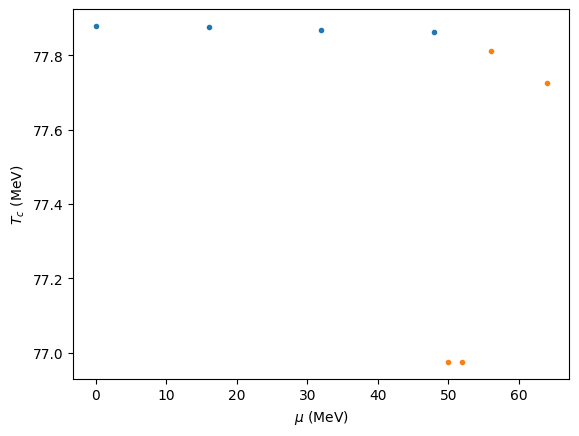

In [ ]:
#find the mu values that have order = 2
indices=np.where(np.array(order_list)==2)[0]
mu_2o=np.array(mu_list)[indices]
Tc_2o=np.array(Tc_list)[indices]

#find the mu values that have order = 1
indices=np.where(np.array(order_list)==1)[0]
mu_1o=np.array(mu_list)[indices]
Tc_1o=np.array(Tc_list)[indices]

#plot the mu values that have order = 2
plt.plot(mu_2o,Tc_2o,'.')
plt.plot(mu_1o,Tc_1o,'.')
plt.xlabel('$\mu$ (MeV)')
plt.ylabel('$T_c$ (MeV)')
plt.show()


In [98]:
import os
# create an array of lambda_1 values from 4.9 to 7.5 in steps of 0.1
lambda1_max=4.8
lambda1_min=4.7
lambda1_step=0.05
#make the array from large to small, because the critical mu value is strictly increasing in that direction
lambda1_array=np.arange(lambda1_max,lambda1_min-lambda1_step,-lambda1_step)

mu_0=300
delta_mu=128
mu_precision=0.5

mq_input=9
mq_tolerance=0.1
tmin=15
tmax=150

# create empty lists to store the critical mu and Tc values
critical_mu_list=[]
critical_Tc_list=[]
lambda1_list=[]


#read in the data from the csv file
try:
    df=pd.read_csv('data/critical_points_mq='+str(mq_input)+'.csv')
    lambda1_list=df['lambda1'].values
    critical_mu_list=df['mu'].values
    critical_Tc_list=df['Tc'].values
    #convert from arrays to lists
    lambda1_list=lambda1_list.tolist()
    critical_mu_list=critical_mu_list.tolist()
    critical_Tc_list=critical_Tc_list.tolist()
except: 
    pass




for lambda1 in lambda1_array:
    print('------- lambda1=',lambda1,' -------')
    # first, check to see if there is already a csv file with the critical point data for this value of lambda1
    filename='data/critical_point_mq='+str(mq_input)+'_lambda1='+str(lambda1)+'.csv'
    if os.path.isfile(filename):
        # if there is, read the data from the csv file
        df=pd.read_csv(filename)
        mu_list=df['mu'].values
        Tc_list=df['Tc'].values
        delta_Tc_list=df['delta_Tc'].values
        order_list=df['order'].values
        #find the mu values that have order = 2
        indices=np.where(np.array(order_list)==2)[0]
        mu_2o=np.array(mu_list)[indices]
        Tc_2o=np.array(Tc_list)[indices]

        #find the mu values that have order = 1
        indices=np.where(np.array(order_list)==1)[0]
        mu_1o=np.array(mu_list)[indices]
        Tc_1o=np.array(Tc_list)[indices]
        mu_upper=mu_1o[0]
        mu_lower=mu_2o[-1]
        T_upper=Tc_1o[0]
        T_lower=Tc_2o[-1]
        critical_mu_list.append((mu_upper+mu_lower)/2)
        critical_Tc_list.append((T_upper+T_lower)/2)
        lambda1_list.append(lambda1)
    else:
        # if there is not, find the critical point data and save it to a csv file

        #check to see if the transition is first-order at mu=0
        # if it is, then there is no critical point, so do not call critical_point_finder
        _,_,Tc,delta_Tc,transition_at_mu_0=sigma_zoom(mq_input,mq_tolerance, lambda1,0,tmin,tmax,numtemps)
        if transition_at_mu_0 == 1:
            critical_mu_list.append(0)
            critical_Tc_list.append(Tc)
            lambda1_list.append(lambda1)
            print('------- NO critical point for the following values -------')
            print('lambda1=',lambda1, "mq = ", mq_input)
        else:
            mu_list,Tc_list,delta_Tc_list,order_list=critical_point_finder(mq_input,mq_tolerance, lambda1,tmin,tmax,numtemps,mu_0,delta_mu,mu_precision)
            data=np.array([mu_list,Tc_list,delta_Tc_list,order_list])
            data=data.T
            #give the columns names
            df=pd.DataFrame(data,columns=['mu','Tc','delta_Tc','order'])
            #save the dataframe to a csv file
            df.to_csv(filename,index=False)
            #find the mu values that have order = 2
            indices=np.where(np.array(order_list)==2)[0]
            mu_2o=np.array(mu_list)[indices]
            Tc_2o=np.array(Tc_list)[indices]

            #find the mu values that have order = 1
            indices=np.where(np.array(order_list)==1)[0]
            mu_1o=np.array(mu_list)[indices]
            Tc_1o=np.array(Tc_list)[indices]
            mu_upper=mu_1o[0]
            mu_lower=mu_2o[-1]
            T_upper=Tc_1o[0]
            T_lower=Tc_2o[-1]
            critical_mu_list.append((mu_upper+mu_lower)/2)
            critical_Tc_list.append((T_upper+T_lower)/2)
            print('------- Critical point found -------')
            print('lambda1=',lambda1, "mq = ", mq_input)
            print('mu=',(mu_upper+mu_lower)/2)
            print('Tc=',(T_upper+T_lower)/2)
    mu_0=mu_lower

#save the critical mu and Tc values to a csv file
# convert the lists to numpy arrays
lambda1_list=np.array(lambda1_list)
critical_mu_list=np.array(critical_mu_list)
critical_Tc_list=np.array(critical_Tc_list)

data=np.array([lambda1_list,critical_mu_list,critical_Tc_list])
data=data.T
#give the columns names
df=pd.DataFrame(data,columns=['lambda1','mu','Tc'])
#save the dataframe to a csv file
df.to_csv('data/critical_points_mq='+str(mq_input)+'.csv',index=False)




------- lambda1= 4.8  -------


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_8728/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 72.85714285714286  and T= 101.78571428571428
Temperature is  72.85714285714286
Temperature is  93.5204081632653
Phase transition between T= 79.0561224489796  and T= 85.25510204081633
Temperature is  79.0561224489796
Temperature is  83.48396501457727
Phase transition between T= 81.71282798833819  and T= 83.04118075801749
Temperature is  81.71282798833819
Temperature is  82.66165139525198
Phase transition between T= 82.28212203248646  and T= 82.5667690545606
Temperature is  82.28212203248646
Temperature is  82.48544133396798
Phase transition between T= 82.3431178229309  and T= 82.40411361337537
Temperature is  82.3431178229309
Temperature is  82.38668624467695
Phase transition between T= 82.37361571815313  and T= 82.38668624467695


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 53.57142857142857  and T= 82.5
Temperature is  53.57142857142857
Temperature is  74.23469387755102
Phase transition between T= 61.836734693877546  and T= 68.03571428571428
Temperature is  61.836734693877546
Temperature is  66.26457725947522
Phase transition between T= 64.49344023323614  and T= 65.82179300291544
Temperature is  64.49344023323614
Temperature is  65.44226364014993
Phase transition between T= 65.15761661807579  and T= 65.44226364014993
Temperature is  65.15761661807579
Temperature is  65.36093591955732
Phase transition between T= 65.42193171000179  and T= 65.44226364014993
Temperature is  65.40159977985363
Temperature is  65.43064539435099
Phase transition between T= 65.42483627145151  and T= 65.43354995580073
mu= 300
transition_order= 2
Tc= 65.42628855217637
Temperature is  15.0
Temperature is  51.020852224018654
Phase transition between T= 47.418767001616786  and T= 58.22502266882238
Temp

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_8728/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 72.85714285714286  and T= 101.78571428571428
Temperature is  72.85714285714286
Temperature is  93.5204081632653
Phase transition between T= 79.0561224489796  and T= 85.25510204081633
Temperature is  79.0561224489796
Temperature is  83.48396501457727
Phase transition between T= 81.71282798833819  and T= 83.04118075801749
Temperature is  81.71282798833819
Temperature is  82.66165139525198
Phase transition between T= 82.0923573511037  and T= 82.37700437317784
Temperature is  82.0923573511037
Temperature is  82.29567665258523
Phase transition between T= 82.19401700184446  and T= 82.25501279228892
Temperature is  82.19401700184446
Temperature is  82.2375854235905
Phase transition between T= 82.21580121271748  and T= 82.2288717392413
Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 43.92857142857143  and T= 72.85714285714286
Temperature is  43.92857142857143
Temperature is  

IndexError: index -1 is out of bounds for axis 0 with size 0

In [13]:
def check_input(mq, lambda1, unique_triplets, tolerance=1e-5):
    # Search for the pair in the first two columns of unique_triplets
    mq_matches = np.isclose(unique_triplets[:, 0], mq, atol=tolerance)
    lambda1_matches = np.isclose(unique_triplets[:, 1], lambda1, atol=tolerance)
    pair_exists = np.any(np.logical_and(mq_matches, lambda1_matches))
    
    if pair_exists:
        # If the pair exists, find the corresponding 'order'
        index = np.where(np.logical_and(mq_matches, lambda1_matches))[0][0]
        order = unique_triplets[index, 2]
        return True, order
    else:
        return False, None

In [17]:
# create an array of quark masses from 10 down to 0 in steps of 1
mq_max= 10
mq_min=0.1
mq_step=0.1
# #make the array from large to small, because the threshold lambda1 value is strictly decreasing in that direction
mq_array=np.arange(mq_max,mq_min-mq_step,-mq_step)
# mq_array=mq_values
tmin =15
tmax =125
mu=0 
mq_tolerance=0.01
mq_lambda_order_array=np.array([[0,0,0]])


for mq in mq_array:
    print('------- mq=',mq,' -------')
    lambda1=6 
    
    delta_lambda1=0.4
    while delta_lambda1>0.01:
        order = 1
        tmin=15
        tmax=125
        while order == 1:
            exists, order = check_input(mq, lambda1, mq_lambda_order_array,tolerance=1e-5)
            #first, check to see if this value of lambda1 has already been checked for this value of mq
            if exists:
                # if it has, then use the value of order that is stored in mq_lambda_order_array
                print('***** Already found ****')
                print('mq=',mq,'lambda1=',lambda1,'order=',order)
            else:
                # use sigma_zoom to find the order at mu=0 for this value of mq
                _,_,_,_,order=sigma_zoom(mq,mq_tolerance, lambda1,mu,tmin,tmax,numtemps)
                # if the order is 2, decrease lambda1 by delta_lambda1
                new_result=np.array([[mq,lambda1,order]])
                mq_lambda_order_array=np.append(mq_lambda_order_array, new_result, axis=0)
                print('***** New value ****')
                print('mq=',mq,'lambda1=',lambda1,'order=',order)
            if order == 1:
                lambda1=lambda1-delta_lambda1
            # if the order is 2, increase lambda1 by delta_lambda1
            if order ==2:
                lambda1=lambda1+delta_lambda1
        delta_lambda1=delta_lambda1/2



------- mq= 10.0  -------


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_48804/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  93.57142857142857
Phase transition between T= 101.42857142857143  and T= 125.0
Temperature is  101.42857142857143
Temperature is  118.26530612244898
Phase transition between T= 113.21428571428572  and T= 118.26530612244898
Temperature is  113.21428571428572
Temperature is  116.82215743440233
first-order transition at T= 115.3790087463557
***** New value ****
mq= 10.0 lambda1= 6 order= 1
Temperature is  15.0
Temperature is  93.57142857142857
Phase transition between T= 93.57142857142857  and T= 117.14285714285714
Temperature is  93.57142857142857
Temperature is  110.40816326530611
Phase transition between T= 103.67346938775509  and T= 108.72448979591836
Temperature is  103.67346938775509
Temperature is  107.28134110787171
Phase transition between T= 106.19897959183672  and T= 107.28134110787171
Temperature is  106.19897959183672
Temperature is  106.97209496043314
Phase transition between T= 106.43091420241565  and T= 106.66284881299457
Temperature is

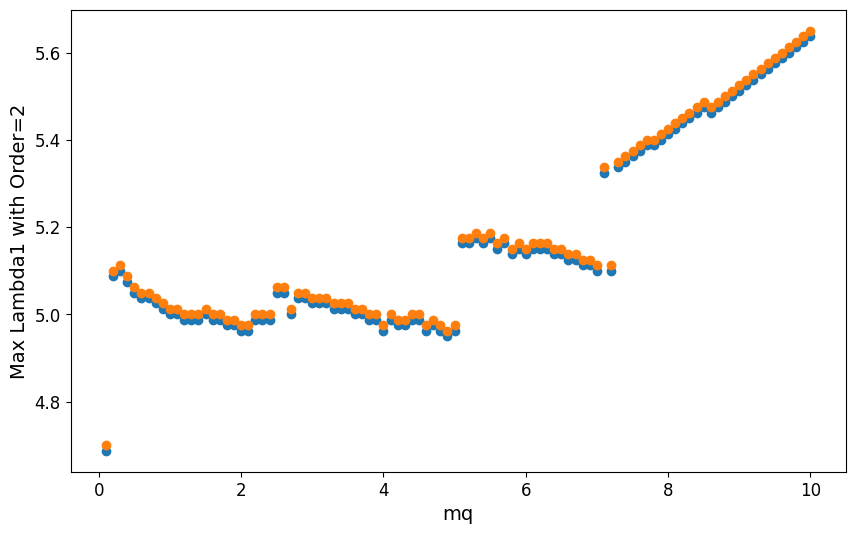

In [18]:

# Extract rows where order is 2
order_2_triplets = mq_lambda_order_array[mq_lambda_order_array[:, 2] == 2]

# Find the largest lambda1 for each mq where order is 2
max_lambda1_per_mq = np.array([order_2_triplets[order_2_triplets[:, 0] == mq][:, 1].max() for mq in np.unique(order_2_triplets[:, 0])])

# Corresponding mq values
mq_values = np.unique(order_2_triplets[:, 0])

# Extract rows where order is 1
order_1_triplets = mq_lambda_order_array[mq_lambda_order_array[:, 2] == 1]

# Find the smallest lambda1 for each mq where order is 1
min_lambda1_per_mq = np.array([order_1_triplets[order_1_triplets[:, 0] == mq][:, 1].min() for mq in np.unique(order_1_triplets[:, 0])])


# Now we will plot max_lambda1_per_mq vs mq_values
import matplotlib.pyplot as plt

# Plotting the graph according to the user's preferences
plt.figure(figsize=(10, 6))
plt.plot(mq_values, max_lambda1_per_mq, 'o')
plt.plot(mq_values, min_lambda1_per_mq, 'o')
plt.xlabel('mq', fontsize=14)
plt.ylabel('Max Lambda1 with Order=2', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [149]:
# find the max_value_per_mq that corresponds to mq=7.5
index=np.where(mq_values==5.5)[0][0]
max_lambda1_per_mq[index]

5.174999999999999

In [19]:
# save mq_lambda_order_array to a csv file with headings mq, lambda1, order
data=mq_lambda_order_array
#give the columns names
df=pd.DataFrame(data,columns=['mq','lambda1','order'])
#save the dataframe to a csv file
df.to_csv('data/order_by_mq_lambda_at_mu_0.csv',index=False)

In [127]:
mq_tolerance

0.01

In [150]:
lambda1=6 
mq=5.5
mq_lambda_order_array_2=np.array([[mq,lambda1,1]])
delta_lambda1=0.4
while delta_lambda1>0.005:
    order = 1
    tmin=15
    tmax=125
    
    while order == 1:
        exists, order = check_input(mq, lambda1, mq_lambda_order_array_2,tolerance=1e-5)
        #first, check to see if this value of lambda1 has already been checked for this value of mq
        if exists:
            # if it has, then use the value of order that is stored in mq_lambda_order_array
            print('***** Already found ****')
            print('mq=',mq,'lambda1=',lambda1,'order=',order)
        else:
            # use sigma_zoom to find the order at mu=0 for this value of mq
            _,_,_,_,order=sigma_zoom(mq,mq_tolerance, lambda1,mu,tmin,tmax,numtemps)
            new_result=np.array([[mq,lambda1,order]])
            mq_lambda_order_array_2=np.append(mq_lambda_order_array_2, new_result, axis=0)
            print('***** New value ****')
            print('mq=',mq,'lambda1=',lambda1,'order=',order)
        if order == 1:
            lambda1=lambda1-delta_lambda1
        # if the order is 2, increase lambda1 by delta_lambda1
        if order ==2:
            lambda1=lambda1+delta_lambda1
    delta_lambda1=delta_lambda1/2

***** Already found ****
mq= 5.5 lambda1= 6 order= 1.0


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_34203/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  26.11111111111111
Temperature is  37.22222222222222
Temperature is  48.333333333333336
Temperature is  59.44444444444444
Temperature is  70.55555555555556
Temperature is  81.66666666666667
Temperature is  92.77777777777779
Temperature is  103.88888888888889
Temperature is  115.0
first-order transition at T= 101.66666666666667
***** New value ****
mq= 5.5 lambda1= 5.6 order= 1
Temperature is  15.0
Temperature is  26.11111111111111
Temperature is  37.22222222222222
Temperature is  48.333333333333336
Temperature is  59.44444444444444
Temperature is  70.55555555555556
Temperature is  81.66666666666667
Temperature is  92.77777777777779
Temperature is  103.88888888888889
Temperature is  115.0
first-order transition at T= 90.55555555555556
***** New value ****
mq= 5.5 lambda1= 5.199999999999999 order= 1
Temperature is  15.0
Temperature is  26.11111111111111
Temperature is  37.22222222222222
Temperature is  48.333333333333336
Temperature is  59.444444444444

In [133]:

mq_lambda_order_array_2

array([[7.5    , 6.     , 1.     ],
       [7.5    , 5.6    , 1.     ],
       [7.5    , 5.2    , 2.     ],
       [7.5    , 5.4    , 1.     ],
       [7.5    , 5.3    , 2.     ],
       [7.5    , 5.35   , 2.     ],
       [7.5    , 5.375  , 1.     ],
       [7.5    , 5.3625 , 2.     ],
       [7.5    , 5.36875, 2.     ]])

In [128]:
mq=7
mq_tolerance=0.01
lambda1=5.6
mu=0
tmin=15
tmax=125
numtemps=15

_,_,_,_,order=sigma_zoom(mq,mq_tolerance, lambda1,mu,tmin,tmax,numtemps)
print(order)

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_34203/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  93.57142857142857
Phase transition between T= 93.57142857142857  and T= 117.14285714285714
Temperature is  93.57142857142857
Temperature is  110.40816326530611
first-order transition at T= 103.67346938775509
1


In [43]:
lambda1=5.6
mq=8
if lambda1 in lambda1_list:
                #if it has, then find the index of this value of lambda1 in lambda1_list
                index=np.where(np.array(lambda1_list)==lambda1)[0]
                #find the values of the corresponding mq
                checked_mq=mq_list[index]
                if mq in checked_mq:
                    #if this value of mq has already been checked for this value of lambda1, then find the index of this value of mq in checked_mq
                    index=np.where(np.array(checked_mq)==mq)[0]
                #and use the corresponding value of mq to find the order
                    order=order_list[index]
order

array([1, 2, 1])

In [ ]:
#save the data to a csv file
data=np.array([mq_unique,lambda1_unique])
data=data.T
#give the columns names
df=pd.DataFrame(data,columns=['mq','lambda1'])
#save the dataframe to a csv file
df.to_csv('data/threshold_lambda_rough.csv',index=False)

In [28]:
#round all the values in lambda1_list to 2 decimal places
lambda1_list=np.round(lambda1_list,2)

In [46]:
#find the values of lambda1_list that corresponde to mq=8
indices=np.where(np.array(mq_list)==8)[0]
lambda1_8=np.array(lambda1_list)[indices]
lambda1_8

array([6. , 5.6, 5.2, 5.6, 5.4, 5.6, 5.5, 5.4])

In [47]:
np.array(order_list)[indices]

array([1, 1, 2, 1, 2, 1, 1, 2])

In [51]:
len(mq_list)

90

In [52]:
len(lambda1_list)

89

In [55]:
good_data=mq_lambda_order_array

In [53]:
# Truncate the mq_list to match the size of the other arrays
mq_list = mq_list[:len(order_list)]

# Now combine the three lists into a 2D numpy array
triplets = np.column_stack((mq_list, lambda1_list, order_list))

# Find the unique rows (ordered triplets) in the array
mq_lambda_order_array = np.unique(triplets, axis=0)
